# Multivariate Time Series Prediction Using Transformers Architecture

The following Notebook shows the coding part of my Bachelor Thesis for the Information and Communication Systems and Services bachelor degree in the University of Applied Science Technikum Wien.

Author: Sergio Tallo Torres
Date: April 2022

# First: load imports needed for the project and project preparation

In [1]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 279 (delta 26), reused 6 (delta 1), pack-reused 226
Receiving objects: 100% (279/279), 12.68 MiB | 14.63 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/Bsc_Thesis
/content


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import math
from torch import Tensor, float32, sin, cos
import torch.nn as nn
import matplotlib.pyplot as plt
import utils_bsc
import datetime
import statistics
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from scipy import stats
from sklearn.decomposition import PCA

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla T4


In [3]:
utils_bsc.print_versions()

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.6
PyTorch: 1.11.0+cu113
Sklearn: 1.0.2
seaborn: 0.11.2


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [4]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the value of the previous elemnt in the sequence).

In [5]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [6]:
print_data = False

if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [7]:
# Set to True to print the graphs

print_graphs = False

if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [8]:
# We print some graphs showing the density distribution of every feature

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [9]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [10]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [11]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very different. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [12]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_norm.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [13]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 663.77it/s]


In [14]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1017.50it/s]


In [15]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 778.84it/s]


In [16]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [17]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [18]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

Covariance matrix of all features

(63360, 18)
<class 'numpy.float64'>


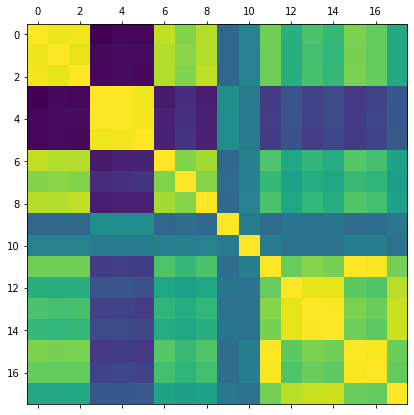

[9.572 2.940 1.352 0.989 0.970 0.891 0.405 0.251 0.230 0.177 0.072 0.052
 0.039 0.031 0.012 0.004 0.004 0.007]
[0.5317647804810275, 0.16335739298653454, 0.07511546472383007, 0.054921627068028396, 0.05390616867076576, 0.04952232661739347, 0.02248634946399557, 0.013932731902136307, 0.012792662672300404, 0.00982901200719907, 0.004024926426955618, 0.0028939596101033747, 0.002163271201445894, 0.001741116222641514, 0.0006928432299861942, 0.000218263374261013, 0.00023351820917082356, 0.00040358513222439905]


In [19]:
import matplotlib.pyplot as plt

set_ = dataset_norm.iloc[:,1:].values

print(set_.shape)
print(type(set_[0][0]))

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cov_matrix = np.cov(set_.T)

fig = plt.figure(figsize=(15, 15))

# Adds subplot on position 1
ax = fig.add_subplot(121)
ax.matshow(cov_matrix)
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print(eigenvalues)

explained_variance = []

for i in eigenvalues:
    explained_variance.append(i/sum(eigenvalues))

print(explained_variance)

# Correlation between features

In [20]:
correlations = []
matrix = []

for i in dataset_norm.columns[1:]:
  feature = []
  for j in dataset_norm.columns[1:]:
    print(f'Correlation between {i} and {j}')
    correlation = stats.pearsonr(dataset_norm[i], dataset_norm[j])[0]
    if i != j:
      correlations.append(abs(correlation))
      feature.append(abs(correlation))
      print(correlation)
  print(f'Mean of {i} correlations: {np.mean(feature)}')
  print('')
  matrix.append(feature)

print(f'Mean of all correlations: {np.mean(correlations)}')

Correlation between PLN1 and PLN1
Correlation between PLN1 and PLN2
0.9530638927686161
Correlation between PLN1 and PLN3
0.9606664987977855
Correlation between PLN1 and ULL1
-0.7274016376341781
Correlation between PLN1 and ULL2
-0.6955282277514698
Correlation between PLN1 and ULL3
-0.7030835410050383
Correlation between PLN1 and COS_PHI1
0.841040129519536
Correlation between PLN1 and COS_PHI2
0.6731338062873105
Correlation between PLN1 and COS_PHI3
0.8122370309192151
Correlation between PLN1 and FREQ
-0.1545159794969927
Correlation between PLN1 and RC_DC
0.04144790238090617
Correlation between PLN1 and RC_AC
0.6311099014117805
Correlation between PLN1 and RC_50Hz
0.36881135461351117
Correlation between PLN1 and RC_150Hz
0.5078743784519384
Correlation between PLN1 and RC_<100Hz
0.43093253308676605
Correlation between PLN1 and RC_100Hz-1kHz
0.6585953463453891
Correlation between PLN1 and RC_>1kHz
0.5928797475823844
Correlation between PLN1 and RC_>10kHz
0.3161918341465538
Mean of PLN1 co

In [21]:
# Covariance matrix, eigenvalues and explained variance

covmatrix = dataset_norm.cov()
eigenvalues, eigenvectors = np.linalg.eig(covmatrix)

acc = 0

for i, eigen in enumerate(eigenvalues):
  acc += eigen/np.sum(eigenvalues)
  print(f'Explained_variance {i +1} principal component: {eigen/np.sum(eigenvalues)} (accumulated {round(acc, 4)})')

Explained_variance 1 principal component: 0.5317647804810276 (accumulated 0.5318)
Explained_variance 2 principal component: 0.16335739298653457 (accumulated 0.6951)
Explained_variance 3 principal component: 0.07511546472383009 (accumulated 0.7702)
Explained_variance 4 principal component: 0.05492162706802841 (accumulated 0.8252)
Explained_variance 5 principal component: 0.053906168670765774 (accumulated 0.8791)
Explained_variance 6 principal component: 0.049522326617393475 (accumulated 0.9286)
Explained_variance 7 principal component: 0.022486349463995574 (accumulated 0.9511)
Explained_variance 8 principal component: 0.013932731902136309 (accumulated 0.965)
Explained_variance 9 principal component: 0.012792662672300408 (accumulated 0.9778)
Explained_variance 10 principal component: 0.009829012007199071 (accumulated 0.9876)
Explained_variance 11 principal component: 0.004024926426955619 (accumulated 0.9917)
Explained_variance 12 principal component: 0.002893959610103375 (accumulated 0.9

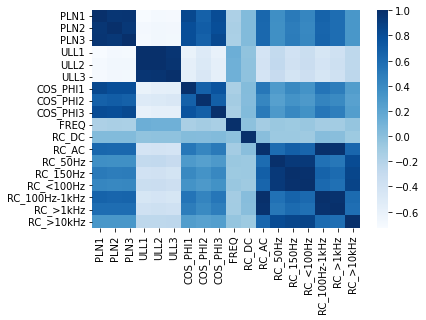

In [22]:
# Features correlations heat map

corr = dataset_norm.corr()
sns.heatmap(corr, cmap="Blues")

# Data loaders for the training

In [23]:
def create_sequece_dataloaders_new(dataset_norm):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of 30 measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 31)):    
    data = np.array(dataset_norm.iloc[i:i+30, 1:])
    next = np.array(dataset_norm.iloc[i+30, 1:], dtype= float)
    target = np.array(dataset_norm.iloc[i+31, 1:], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=16,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=16,
      shuffle=True
  )

  return loader_train, loader_test

In [24]:
loader_train_seq, loader_test_seq = create_sequece_dataloaders_new(dataset_norm)

100%|██████████| 63329/63329 [00:41<00:00, 1513.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56996
length of test set (whole dataset): 6333




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [25]:
def create_dataloaders_new(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
  # When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) -1)):
    data = np.array([j for j in dataset_norm.iloc[i, 1:]])
    target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=16,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=16,
      shuffle=True
  )

  return loader_train, loader_test

In [26]:
loader_train, loader_test = create_dataloaders_new(dataset_norm)

100%|██████████| 63359/63359 [00:20<00:00, 3113.76it/s]


length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




In [36]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

# save to npy file
if True:
  np.save('baseline_train.npy', losses_train)
  np.save('baseline_test.npy', losses_test)

Training set
Mean Loss of baselinemodel:  0.47263242820054124
Standard deviation Loss of baselinemodel:  0.17774659731197265


Test set
Mean Loss of baselinemodel:  0.47636275168395403
Standard deviation Loss of baselinemodel:  0.18142434392159165




In [28]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 640)
        self.linear3 = nn.Linear(640, 180)
        self.linear4 = nn.Linear(180, D_out)

        self.relu = torch.nn.ReLU()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)

        return self.linear4(x)

# This function trains the model for one epoch
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs):

    epoch_loss_train = []
    epoch_loss_test = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      print('Train')
      model.train()

      for i in tqdm(train_loader):

        data, target = i[0], i[1]

        optimizer.zero_grad()

        # Forward Pass
        output = model(data)

        #Compute loss
        loss = criterion(output, target)

        #Backpropagation
        loss.backward()

        #Optimization
        optimizer.step()

      losses = []

      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(train_loader):

          data, target = i[0], i[1]

          output = model(data)
              
          losses.append (float(criterion(output, target).item()))

      print('\nCurrent Mean loss Train: ', np.mean(losses))
      epoch_loss_train.append(losses)

      losses = []

      print('\nTest with test set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(test_loader):

          data, target = i[0], i[1]

          output = model(data)
            
          losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss_test.append(losses)

    return model, epoch_loss_train, epoch_loss_test

In [ ]:
n_epochs = 200
lr=0.01

# Create model FFN instance
model_FFN = ANN_relu(18, 18).to(device)
print(model_FFN_whole)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_whole = torch.optim.SGD(model_FFN.parameters(), lr=lr)


train_FFN = True

params_not_trained_whole = model_FFN.parameters()

start_time = datetime.now()
if train_FFN is True:
  trained_model_FFN , train_losses_FFN, test_losses_FFN = train(model_FFN, criterion, optimizer_whole, loader_train, loader_test, n_epochs)

end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'\nTraining time: {execution_time} seconds')

# save to npy file
if True:
  np.save('FFN_train.npy', losses_train)
  np.save('FFN_test.npy', losses_test)

ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 1:
Train


100%|██████████| 3564/3564 [00:04<00:00, 747.17it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2217.45it/s]



Current Mean loss Train:  0.3303875571407386

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2295.31it/s]



Current Mean loss:  0.32939304765125715

Epoch 2:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.22it/s]



Test with training set


 18%|█▊        | 657/3564 [00:00<00:01, 2203.82it/s]

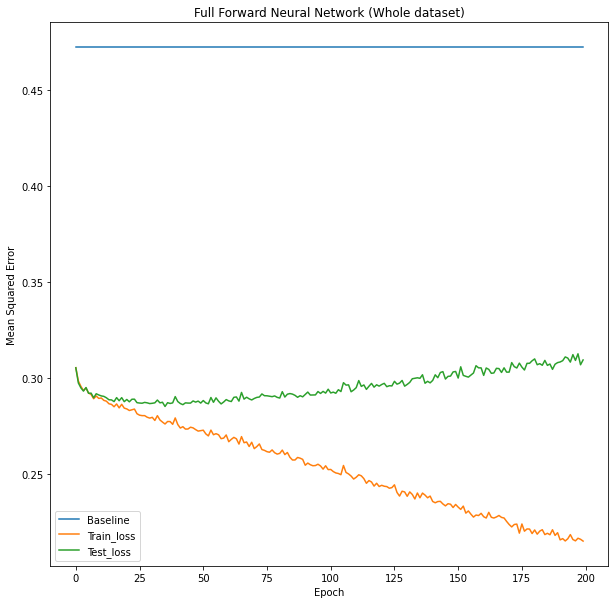

In [30]:
if train_FFN is True:

  # Show results of the loss function whole

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses_whole))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_whole], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_whole], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Whole dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [31]:
class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, dim_feedforward: int=2048, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)

    def positional_encoding(self, seq_len: int, dim_model: int, device):

        position_encoding = torch.zeros(seq_len, dim_model)

        for pos in range(seq_len):
          for i in range(0, int(dim_model / 2)):
            position_encoding[pos, 2 * i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
            position_encoding[pos, (2 * i) + 1] = math.cos(pos / (10000 ** ((2 * i)/dim_model)))

        position_encoding = position_encoding.to(device)

        return position_encoding
        
    def forward (self, enc_input, dec_input):
        
        memory_mask = self.generate_square_mask(len(enc_input))

        src_pos_enc = enc_input + self.positional_encoding(seq_len= enc_input.shape[1], dim_model= enc_input.shape[2], device= self.device)
        src_pos_dec = dec_input + self.positional_encoding(seq_len= dec_input.shape[1], dim_model= dec_input.shape[2], device= self.device)

        output = self.encoder (src= src_pos_enc, mask=None)
        output = self.decoder (tgt= src_pos_dec, memory= output, tgt_mask=None, memory_mask=None)
        
        return output

In [32]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs, device):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [33]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = False

if train_transformer is True:
  trained_model_transformer_1, train_losses_1, test_losses_1 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_Vanilla_train.npy', train_losses_1)
  np.save('Transformer_Vanilla_test.npy', test_losses_1)

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.07it/s]



Current Mean loss Train Set:  0.4135045367171515

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.92it/s]



Current Mean loss Test Set:  0.42151523885702846


Epoch: 2 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 40.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.56it/s]



Current Mean loss Train Set:  0.3808497270689966

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.86it/s]



Current Mean loss Test Set:  0.39023017322625775


Epoch: 3 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.95it/s]



Current Mean loss Train Set:  0.3673461053500576

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.09it/s]



Current Mean loss Test Set:  0.37713876953630737


Epoch: 4 of 200
Training...


100%|██████████| 3563/3563 [01:27<00:00, 40.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.54it/s]



Current Mean loss Train Set:  0.35879987129042934

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.24it/s]



Current Mean loss Test Set:  0.3685171137554477


Epoch: 5 of 200
Training...


100%|██████████| 3563/3563 [01:27<00:00, 40.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.40it/s]



Current Mean loss Train Set:  0.3543248327091909

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.36it/s]



Current Mean loss Test Set:  0.36382451604562577


Epoch: 6 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.21it/s]



Current Mean loss Train Set:  0.350501330735106

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.94it/s]



Current Mean loss Test Set:  0.3604470922639876


Epoch: 7 of 200
Training...


100%|██████████| 3563/3563 [01:27<00:00, 40.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.90it/s]



Current Mean loss Train Set:  0.34747359995138705

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.75it/s]



Current Mean loss Test Set:  0.3574712906747755


Epoch: 8 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.26it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 117.94it/s]



Current Mean loss Train Set:  0.34458785866071695

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.63it/s]



Current Mean loss Test Set:  0.3550751761655615


Epoch: 9 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.13it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.40it/s]



Current Mean loss Train Set:  0.3421485983033947

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.18it/s]



Current Mean loss Test Set:  0.35264251053784834


Epoch: 10 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.99it/s]



Current Mean loss Train Set:  0.3401230276760144

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.50it/s]



Current Mean loss Test Set:  0.35088572451713107


Epoch: 11 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 40.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.97it/s]



Current Mean loss Train Set:  0.33887620127012047

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.57it/s]



Current Mean loss Test Set:  0.3493728572973097


Epoch: 12 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.35it/s]



Current Mean loss Train Set:  0.3359978093739276

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.98it/s]



Current Mean loss Test Set:  0.346342350836053


Epoch: 13 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.90it/s]



Current Mean loss Train Set:  0.3347277693197428

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.27it/s]



Current Mean loss Test Set:  0.34525328129529953


Epoch: 14 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 40.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.46it/s]



Current Mean loss Train Set:  0.33293661512403117

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.39it/s]



Current Mean loss Test Set:  0.3439543866599449


Epoch: 15 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.56it/s]



Current Mean loss Train Set:  0.33217615290635627

Test with test set


100%|██████████| 396/396 [00:03<00:00, 116.85it/s]



Current Mean loss Test Set:  0.3426683436364237


Epoch: 16 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.69it/s]



Current Mean loss Train Set:  0.3305742694836067

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.04it/s]



Current Mean loss Test Set:  0.3414163544322505


Epoch: 17 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.48it/s]



Current Mean loss Train Set:  0.3295154189155104

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.27it/s]



Current Mean loss Test Set:  0.34047022177790753


Epoch: 18 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.77it/s]



Current Mean loss Train Set:  0.32882416355803945

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.07it/s]



Current Mean loss Test Set:  0.33963047600153723


Epoch: 19 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.16it/s]



Current Mean loss Train Set:  0.3281493896690105

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.84it/s]



Current Mean loss Test Set:  0.3394182032406932


Epoch: 20 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.16it/s]



Current Mean loss Train Set:  0.3272710063970728

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.87it/s]



Current Mean loss Test Set:  0.3381667367812961


Epoch: 21 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.49it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.10it/s]



Current Mean loss Train Set:  0.32695082699084865

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.02it/s]



Current Mean loss Test Set:  0.337661720097366


Epoch: 22 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.52it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.22it/s]



Current Mean loss Train Set:  0.32512637452566656

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.63it/s]



Current Mean loss Test Set:  0.3358229631275842


Epoch: 23 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.52it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.48it/s]



Current Mean loss Train Set:  0.3243398158412417

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.39it/s]



Current Mean loss Test Set:  0.33530405826038784


Epoch: 24 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.50it/s]



Current Mean loss Train Set:  0.32559392676112897

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.98it/s]



Current Mean loss Test Set:  0.3371933388213317


Epoch: 25 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.57it/s]



Current Mean loss Train Set:  0.3238260398670893

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.35it/s]



Current Mean loss Test Set:  0.3344397367627332


Epoch: 26 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.64it/s]



Current Mean loss Train Set:  0.32206677392003846

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.68it/s]



Current Mean loss Test Set:  0.3324573022322823


Epoch: 27 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.33it/s]



Current Mean loss Train Set:  0.3213012139808252

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.44it/s]



Current Mean loss Test Set:  0.3329321075644758


Epoch: 28 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.68it/s]



Current Mean loss Train Set:  0.3206449969661995

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.11it/s]



Current Mean loss Test Set:  0.33216649907255413


Epoch: 29 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.40it/s]



Current Mean loss Train Set:  0.3188186242628593

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.19it/s]



Current Mean loss Test Set:  0.33016933192207354


Epoch: 30 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.58it/s]



Current Mean loss Train Set:  0.3171916060523976

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.45it/s]



Current Mean loss Test Set:  0.32848920812359966


Epoch: 31 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.52it/s]



Current Mean loss Train Set:  0.3137182810882521

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.60it/s]



Current Mean loss Test Set:  0.3251909768641597


Epoch: 32 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.26it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.46it/s]



Current Mean loss Train Set:  0.31114609383931163

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.00it/s]



Current Mean loss Test Set:  0.3225552642887289


Epoch: 33 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.04it/s]



Current Mean loss Train Set:  0.3078997301049123

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.21it/s]



Current Mean loss Test Set:  0.3198791489080347


Epoch: 34 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.26it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.97it/s]



Current Mean loss Train Set:  0.30974093788867246

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.29it/s]



Current Mean loss Test Set:  0.32216603060563404


Epoch: 35 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.66it/s]



Current Mean loss Train Set:  0.3096595040673859

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.67it/s]



Current Mean loss Test Set:  0.32237388092008507


Epoch: 36 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.71it/s]



Current Mean loss Train Set:  0.30482470955142404

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.55it/s]



Current Mean loss Test Set:  0.31685719097202475


Epoch: 37 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.38it/s]



Current Mean loss Train Set:  0.30177431935854854

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.05it/s]



Current Mean loss Test Set:  0.3143869817181669


Epoch: 38 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.32it/s]



Current Mean loss Train Set:  0.29968467037554974

Test with test set


100%|██████████| 396/396 [00:03<00:00, 114.30it/s]



Current Mean loss Test Set:  0.31269478814845736


Epoch: 39 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.23it/s]



Current Mean loss Train Set:  0.30212136741948203

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.03it/s]



Current Mean loss Test Set:  0.31493387269702827


Epoch: 40 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.28it/s]



Current Mean loss Train Set:  0.29691854708572135

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.79it/s]



Current Mean loss Test Set:  0.30895007571036165


Epoch: 41 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.96it/s]



Current Mean loss Train Set:  0.2970894801731261

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.74it/s]



Current Mean loss Test Set:  0.31045090444762297


Epoch: 42 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:31<00:00, 114.55it/s]



Current Mean loss Train Set:  0.2965296532581303

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.84it/s]



Current Mean loss Test Set:  0.3104917999507502


Epoch: 43 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.02it/s]



Current Mean loss Train Set:  0.29728075659930825

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.21it/s]



Current Mean loss Test Set:  0.3111042357379138


Epoch: 44 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.78it/s]



Current Mean loss Train Set:  0.29124792075971856

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.60it/s]



Current Mean loss Test Set:  0.3043981547834295


Epoch: 45 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.16it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.54it/s]



Current Mean loss Train Set:  0.2950821592985597

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.63it/s]



Current Mean loss Test Set:  0.30804164098067716


Epoch: 46 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.97it/s]



Current Mean loss Train Set:  0.28746103854609983

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.59it/s]



Current Mean loss Test Set:  0.301551715329741


Epoch: 47 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.45it/s]



Current Mean loss Train Set:  0.2923443013848698

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.44it/s]



Current Mean loss Test Set:  0.30603214921523825


Epoch: 48 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.95it/s]



Current Mean loss Train Set:  0.2904315825667804

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.43it/s]



Current Mean loss Test Set:  0.30417520003487364


Epoch: 49 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.13it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.26it/s]



Current Mean loss Train Set:  0.28499314771746104

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.09it/s]



Current Mean loss Test Set:  0.2983841144978398


Epoch: 50 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.05it/s]



Current Mean loss Train Set:  0.2898553725715738

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.43it/s]



Current Mean loss Test Set:  0.3029438264743246


Epoch: 51 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.83it/s]



Current Mean loss Train Set:  0.2827355464125262

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.07it/s]



Current Mean loss Test Set:  0.296370873810968


Epoch: 52 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.71it/s]



Current Mean loss Train Set:  0.28072553709329195

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.21it/s]



Current Mean loss Test Set:  0.29355163552393815


Epoch: 53 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.16it/s]



Current Mean loss Train Set:  0.27967583354632575

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.18it/s]



Current Mean loss Test Set:  0.29323011971633844


Epoch: 54 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.61it/s]



Current Mean loss Train Set:  0.28288561163442444

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.82it/s]



Current Mean loss Test Set:  0.2963817360425236


Epoch: 55 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.24it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.69it/s]



Current Mean loss Train Set:  0.2791684376383778

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.20it/s]



Current Mean loss Test Set:  0.2922353084302611


Epoch: 56 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.71it/s]



Current Mean loss Train Set:  0.27795861874726124

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.37it/s]



Current Mean loss Test Set:  0.2912338564191202


Epoch: 57 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.43it/s]



Current Mean loss Train Set:  0.2790475889262509

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.15it/s]



Current Mean loss Test Set:  0.2924129074683996


Epoch: 58 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.13it/s]



Current Mean loss Train Set:  0.27814372419608363

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.05it/s]



Current Mean loss Test Set:  0.29120992673466906


Epoch: 59 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.62it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.13it/s]



Current Mean loss Train Set:  0.2747666080856872

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.53it/s]



Current Mean loss Test Set:  0.2875154498738773


Epoch: 60 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.55it/s]



Current Mean loss Train Set:  0.2750099479395153

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.37it/s]



Current Mean loss Test Set:  0.28791277061658677


Epoch: 61 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.43it/s]



Current Mean loss Train Set:  0.2728299361361134

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.51it/s]



Current Mean loss Test Set:  0.28585374763592925


Epoch: 62 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.38it/s]



Current Mean loss Train Set:  0.2763424420809264

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.38it/s]



Current Mean loss Test Set:  0.28942281854423607


Epoch: 63 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.13it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.88it/s]



Current Mean loss Train Set:  0.2748490355798043

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.45it/s]



Current Mean loss Test Set:  0.28834484254169945


Epoch: 64 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.61it/s]



Current Mean loss Train Set:  0.27474422833155354

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.53it/s]



Current Mean loss Test Set:  0.28797479910832463


Epoch: 65 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.04it/s]



Current Mean loss Train Set:  0.27169112057965894

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.63it/s]



Current Mean loss Test Set:  0.2847948614131622


Epoch: 66 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.22it/s]



Current Mean loss Train Set:  0.2717207382184014

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.39it/s]



Current Mean loss Test Set:  0.28495142546792823


Epoch: 67 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.01it/s]



Current Mean loss Train Set:  0.2769677449010444

Test with test set


100%|██████████| 396/396 [00:03<00:00, 115.58it/s]



Current Mean loss Test Set:  0.2904689587615054


Epoch: 68 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.56it/s]



Current Mean loss Train Set:  0.26995247040375747

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.69it/s]



Current Mean loss Test Set:  0.2835348974348921


Epoch: 69 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.56it/s]



Current Mean loss Train Set:  0.2722899416148445

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.10it/s]



Current Mean loss Test Set:  0.28590198350374146


Epoch: 70 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.93it/s]



Current Mean loss Train Set:  0.26868895082461375

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.77it/s]



Current Mean loss Test Set:  0.28133601505271716


Epoch: 71 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.40it/s]



Current Mean loss Train Set:  0.26837775778885875

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.05it/s]



Current Mean loss Test Set:  0.2812836608200362


Epoch: 72 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.69it/s]



Current Mean loss Train Set:  0.27288234914926673

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.40it/s]



Current Mean loss Test Set:  0.28579823006734706


Epoch: 73 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.94it/s]



Current Mean loss Train Set:  0.2668055874697285

Test with test set


100%|██████████| 396/396 [00:03<00:00, 113.55it/s]



Current Mean loss Test Set:  0.27996773541801506


Epoch: 74 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.35it/s]



Current Mean loss Train Set:  0.26630010302360224

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.87it/s]



Current Mean loss Test Set:  0.27949552401674516


Epoch: 75 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.11it/s]



Current Mean loss Train Set:  0.26561066694191726

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.75it/s]



Current Mean loss Test Set:  0.2789687310543024


Epoch: 76 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.43it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.81it/s]



Current Mean loss Train Set:  0.2676346847934399

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.89it/s]



Current Mean loss Test Set:  0.2805156634386742


Epoch: 77 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.58it/s]



Current Mean loss Train Set:  0.27257514258398624

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.84it/s]



Current Mean loss Test Set:  0.28604395501315594


Epoch: 78 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.87it/s]



Current Mean loss Train Set:  0.2658014148201897

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.16it/s]



Current Mean loss Test Set:  0.27874289200914026


Epoch: 79 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.08it/s]



Current Mean loss Train Set:  0.2711681788962375

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.72it/s]



Current Mean loss Test Set:  0.28450140065391255


Epoch: 80 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.73it/s]



Current Mean loss Train Set:  0.26503547408374684

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.91it/s]



Current Mean loss Test Set:  0.2779223949582589


Epoch: 81 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.33it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.22it/s]



Current Mean loss Train Set:  0.2648051123404282

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.89it/s]



Current Mean loss Test Set:  0.2776507004493415


Epoch: 82 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.41it/s]



Current Mean loss Train Set:  0.264306615319792

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.60it/s]



Current Mean loss Test Set:  0.27683388264943853


Epoch: 83 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.45it/s]



Current Mean loss Train Set:  0.2630853618450992

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.52it/s]



Current Mean loss Test Set:  0.2764193270204946


Epoch: 84 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.20it/s]



Current Mean loss Train Set:  0.2627449905729314

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.58it/s]



Current Mean loss Test Set:  0.27583383546784673


Epoch: 85 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.91it/s]



Current Mean loss Train Set:  0.26300423446788634

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.18it/s]



Current Mean loss Test Set:  0.27547769188278853


Epoch: 86 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.86it/s]



Current Mean loss Train Set:  0.2629977763932875

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.74it/s]



Current Mean loss Test Set:  0.27639537169174716


Epoch: 87 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.75it/s]



Current Mean loss Train Set:  0.26198371651590524

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.13it/s]



Current Mean loss Test Set:  0.2745500733379764


Epoch: 88 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.31it/s]



Current Mean loss Train Set:  0.263627951295062

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.97it/s]



Current Mean loss Test Set:  0.27705243843221905


Epoch: 89 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.09it/s]



Current Mean loss Train Set:  0.2616341453659344

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.10it/s]



Current Mean loss Test Set:  0.27462917882384674


Epoch: 90 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.29it/s]



Current Mean loss Train Set:  0.2618821164027981

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.49it/s]



Current Mean loss Test Set:  0.27524464837077894


Epoch: 91 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.02it/s]



Current Mean loss Train Set:  0.2631509454438367

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.74it/s]



Current Mean loss Test Set:  0.2763580298145311


Epoch: 92 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.79it/s]



Current Mean loss Train Set:  0.26041300822527197

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.71it/s]



Current Mean loss Test Set:  0.27405499098728403


Epoch: 93 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.72it/s]



Current Mean loss Train Set:  0.2618913315874353

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.36it/s]



Current Mean loss Test Set:  0.2740922722626816


Epoch: 94 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.35it/s]



Current Mean loss Train Set:  0.2596034446510076

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.49it/s]



Current Mean loss Test Set:  0.2719123890491748


Epoch: 95 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.66it/s]



Current Mean loss Train Set:  0.26092747543054184

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.12it/s]



Current Mean loss Test Set:  0.2739977209330207


Epoch: 96 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.94it/s]



Current Mean loss Train Set:  0.2601424607372739

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.94it/s]



Current Mean loss Test Set:  0.2735825946197064


Epoch: 97 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.83it/s]



Current Mean loss Train Set:  0.26320639378337624

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.67it/s]



Current Mean loss Test Set:  0.27584403200131474


Epoch: 98 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.30it/s]



Current Mean loss Train Set:  0.26343562712653984

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.53it/s]



Current Mean loss Test Set:  0.27685214966686084


Epoch: 99 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.41it/s]



Current Mean loss Train Set:  0.2614975975904276

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.91it/s]



Current Mean loss Test Set:  0.27515763687816536


Epoch: 100 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.68it/s]



Current Mean loss Train Set:  0.25992609551707047

Test with test set


100%|██████████| 396/396 [00:03<00:00, 116.49it/s]



Current Mean loss Test Set:  0.27286462267540923


Epoch: 101 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.54it/s]



Current Mean loss Train Set:  0.2589161664920846

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.20it/s]



Current Mean loss Test Set:  0.2720706903121688


Epoch: 102 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.00it/s]



Current Mean loss Train Set:  0.2576902844377726

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.56it/s]



Current Mean loss Test Set:  0.27084816489933117


Epoch: 103 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.59it/s]



Current Mean loss Train Set:  0.25853659802906104

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.58it/s]



Current Mean loss Test Set:  0.27135318813074116


Epoch: 104 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.66it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.84it/s]



Current Mean loss Train Set:  0.25728255816675993

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.69it/s]



Current Mean loss Test Set:  0.2698016037995165


Epoch: 105 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.69it/s]



Current Mean loss Train Set:  0.2587766424009648

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.12it/s]



Current Mean loss Test Set:  0.2725966705028156


Epoch: 106 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.63it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.67it/s]



Current Mean loss Train Set:  0.25697054523883694

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.78it/s]



Current Mean loss Test Set:  0.27121769969887805


Epoch: 107 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.18it/s]



Current Mean loss Train Set:  0.2589570620493744

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.00it/s]



Current Mean loss Test Set:  0.2728403669716132


Epoch: 108 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.84it/s]



Current Mean loss Train Set:  0.2577847589498452

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.13it/s]



Current Mean loss Test Set:  0.2718613724403008


Epoch: 109 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.53it/s]



Current Mean loss Train Set:  0.2562226163405834

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.71it/s]



Current Mean loss Test Set:  0.268745409193063


Epoch: 110 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.64it/s]



Current Mean loss Train Set:  0.2578970940635675

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.77it/s]



Current Mean loss Test Set:  0.27180189552782763


Epoch: 111 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.74it/s]



Current Mean loss Train Set:  0.25605343025435967

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.98it/s]



Current Mean loss Test Set:  0.26996703758233725


Epoch: 112 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 42.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.68it/s]



Current Mean loss Train Set:  0.2566382613554785

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.49it/s]



Current Mean loss Test Set:  0.2703384600128188


Epoch: 113 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.40it/s]



Current Mean loss Train Set:  0.2571472230061801

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.36it/s]



Current Mean loss Test Set:  0.2708700063139802


Epoch: 114 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.57it/s]



Current Mean loss Train Set:  0.25702903586811743

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.12it/s]



Current Mean loss Test Set:  0.27016993401327516


Epoch: 115 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.30it/s]



Current Mean loss Train Set:  0.25653191038164036

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.89it/s]



Current Mean loss Test Set:  0.26960486450204346


Epoch: 116 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.55it/s]



Current Mean loss Train Set:  0.2559991370329287

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.02it/s]



Current Mean loss Test Set:  0.2687147380125643


Epoch: 117 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.75it/s]



Current Mean loss Train Set:  0.25529791814137337

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.46it/s]



Current Mean loss Test Set:  0.2683609550950503


Epoch: 118 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.13it/s]



Current Mean loss Train Set:  0.25442300337295404

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.12it/s]



Current Mean loss Test Set:  0.2679722991141707


Epoch: 119 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.36it/s]



Current Mean loss Train Set:  0.2547866189426296

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.11it/s]



Current Mean loss Test Set:  0.26813326247337493


Epoch: 120 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.84it/s]



Current Mean loss Train Set:  0.25339622412074525

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.51it/s]



Current Mean loss Test Set:  0.2670817492021756


Epoch: 121 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 42.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.58it/s]



Current Mean loss Train Set:  0.25792028214609963

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.53it/s]



Current Mean loss Test Set:  0.2711986560148723


Epoch: 122 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.03it/s]



Current Mean loss Train Set:  0.2541201479843818

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.05it/s]



Current Mean loss Test Set:  0.2675685922831598


Epoch: 123 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.96it/s]



Current Mean loss Train Set:  0.25488495139586537

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.65it/s]



Current Mean loss Test Set:  0.26903889283086313


Epoch: 124 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.17it/s]



Current Mean loss Train Set:  0.2532728391895795

Test with test set


100%|██████████| 396/396 [00:03<00:00, 128.06it/s]



Current Mean loss Test Set:  0.2668482839609637


Epoch: 125 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.19it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.87it/s]



Current Mean loss Train Set:  0.2532948920591608

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.00it/s]



Current Mean loss Test Set:  0.2662054353741684


Epoch: 126 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.78it/s]



Current Mean loss Train Set:  0.2545252570544205

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.23it/s]



Current Mean loss Test Set:  0.2678712713108821


Epoch: 127 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.98it/s]



Current Mean loss Train Set:  0.25401529729567046

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.77it/s]



Current Mean loss Test Set:  0.26780352109309397


Epoch: 128 of 200
Training...


100%|██████████| 3563/3563 [01:21<00:00, 43.52it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.61it/s]



Current Mean loss Train Set:  0.2538532985187701

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.03it/s]



Current Mean loss Test Set:  0.2679389153767114


Epoch: 129 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.29it/s]



Current Mean loss Train Set:  0.25382223345157373

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.98it/s]



Current Mean loss Test Set:  0.26786748534350685


Epoch: 130 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.01it/s]



Current Mean loss Train Set:  0.2519236748581718

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.36it/s]



Current Mean loss Test Set:  0.2663375604521446


Epoch: 131 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.00it/s]



Current Mean loss Train Set:  0.2530326823187182

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.54it/s]



Current Mean loss Test Set:  0.2666909717061002


Epoch: 132 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.41it/s]



Current Mean loss Train Set:  0.25193932279630754

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.96it/s]



Current Mean loss Test Set:  0.26603429967706854


Epoch: 133 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.87it/s]



Current Mean loss Train Set:  0.2538237565401194

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.02it/s]



Current Mean loss Test Set:  0.26791633902625606


Epoch: 134 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.94it/s]



Current Mean loss Train Set:  0.25098863188015286

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.27it/s]



Current Mean loss Test Set:  0.2654553214370301


Epoch: 135 of 200
Training...


100%|██████████| 3563/3563 [01:21<00:00, 43.46it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.87it/s]



Current Mean loss Train Set:  0.25289186483357284

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.21it/s]



Current Mean loss Test Set:  0.26726740768009966


Epoch: 136 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.43it/s]



Current Mean loss Train Set:  0.25308718043216116

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.85it/s]



Current Mean loss Test Set:  0.2674040562200426


Epoch: 137 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.19it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.26it/s]



Current Mean loss Train Set:  0.25133947770882614

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.56it/s]



Current Mean loss Test Set:  0.26531938425820284


Epoch: 138 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.88it/s]



Current Mean loss Train Set:  0.251814990999439

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.33it/s]



Current Mean loss Test Set:  0.26600436815484


Epoch: 139 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.32it/s]



Current Mean loss Train Set:  0.2555045085176805

Test with test set


100%|██████████| 396/396 [00:03<00:00, 127.47it/s]



Current Mean loss Test Set:  0.27082499556920747


Epoch: 140 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.35it/s]



Current Mean loss Train Set:  0.25185576285994393

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.20it/s]



Current Mean loss Test Set:  0.26624418971966013


Epoch: 141 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.30it/s]



Current Mean loss Train Set:  0.2503443638528293

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.84it/s]



Current Mean loss Test Set:  0.26511080233812934


Epoch: 142 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.23it/s]



Current Mean loss Train Set:  0.249969016199128

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.65it/s]



Current Mean loss Test Set:  0.2640503592826802


Epoch: 143 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.27it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.74it/s]



Current Mean loss Train Set:  0.2521366412251343

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.52it/s]



Current Mean loss Test Set:  0.2674922379994332


Epoch: 144 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.00it/s]



Current Mean loss Train Set:  0.2520525867881114

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.41it/s]



Current Mean loss Test Set:  0.26688787499160477


Epoch: 145 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.68it/s]



Current Mean loss Train Set:  0.24944226272088438

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.62it/s]



Current Mean loss Test Set:  0.2633487228492294


Epoch: 146 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.74it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.16it/s]



Current Mean loss Train Set:  0.2517772318731022

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.71it/s]



Current Mean loss Test Set:  0.2670339564933921


Epoch: 147 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.58it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.78it/s]



Current Mean loss Train Set:  0.24991541559939434

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.04it/s]



Current Mean loss Test Set:  0.2640178985141142


Epoch: 148 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.22it/s]



Current Mean loss Train Set:  0.24771430686956838

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.94it/s]



Current Mean loss Test Set:  0.2622422528914129


Epoch: 149 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.15it/s]



Current Mean loss Train Set:  0.24928976960925617

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.21it/s]



Current Mean loss Test Set:  0.26312991318227064


Epoch: 150 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.32it/s]



Current Mean loss Train Set:  0.2500796766887379

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.14it/s]



Current Mean loss Test Set:  0.26433994359515534


Epoch: 151 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.66it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.34it/s]



Current Mean loss Train Set:  0.24964381668454236

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.51it/s]



Current Mean loss Test Set:  0.2633585627331878


Epoch: 152 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.77it/s]



Current Mean loss Train Set:  0.2483735933163813

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.20it/s]



Current Mean loss Test Set:  0.2629025299854652


Epoch: 153 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.70it/s]



Current Mean loss Train Set:  0.2492268281959263

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.40it/s]



Current Mean loss Test Set:  0.26319749706020257


Epoch: 154 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.61it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.22it/s]



Current Mean loss Train Set:  0.2472549736407778

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.94it/s]



Current Mean loss Test Set:  0.2613702785562385


Epoch: 155 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.58it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.55it/s]



Current Mean loss Train Set:  0.24768601035071397

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.78it/s]



Current Mean loss Test Set:  0.26142039413403984


Epoch: 156 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.60it/s]



Current Mean loss Train Set:  0.2482886672931677

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.22it/s]



Current Mean loss Test Set:  0.2621448693251369


Epoch: 157 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.61it/s]



Current Mean loss Train Set:  0.2487880901409741

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.14it/s]



Current Mean loss Test Set:  0.2633232589848716


Epoch: 158 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.75it/s]



Current Mean loss Train Set:  0.24697497704333213

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.56it/s]



Current Mean loss Test Set:  0.2613927029600047


Epoch: 159 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.58it/s]



Current Mean loss Train Set:  0.24771725857505428

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.07it/s]



Current Mean loss Test Set:  0.2635823823887892


Epoch: 160 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.73it/s]



Current Mean loss Train Set:  0.24787449772743372

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.58it/s]



Current Mean loss Test Set:  0.2636261582562719


Epoch: 161 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.03it/s]



Current Mean loss Train Set:  0.250667942766808

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.76it/s]



Current Mean loss Test Set:  0.2660430633660519


Epoch: 162 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.63it/s]



Current Mean loss Train Set:  0.2502143376418255

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.94it/s]



Current Mean loss Test Set:  0.2650086756870903


Epoch: 163 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.96it/s]



Current Mean loss Train Set:  0.24984965449784066

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.23it/s]



Current Mean loss Test Set:  0.26588772517638376


Epoch: 164 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.66it/s]



Current Mean loss Train Set:  0.248422237843434

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.77it/s]



Current Mean loss Test Set:  0.26338456271950045


Epoch: 165 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.39it/s]



Current Mean loss Train Set:  0.24579774374427202

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.63it/s]



Current Mean loss Test Set:  0.2604331401449562


Epoch: 166 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.77it/s]



Current Mean loss Train Set:  0.24690733979023008

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.84it/s]



Current Mean loss Test Set:  0.26142070436793746


Epoch: 167 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.51it/s]



Current Mean loss Train Set:  0.24886084733770833

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.38it/s]



Current Mean loss Test Set:  0.2647507992206198


Epoch: 168 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.57it/s]



Current Mean loss Train Set:  0.24603563789701716

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.39it/s]



Current Mean loss Test Set:  0.26015597045647376


Epoch: 169 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.64it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.61it/s]



Current Mean loss Train Set:  0.2461649442581424

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.93it/s]



Current Mean loss Test Set:  0.26118847136997214


Epoch: 170 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.23it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.06it/s]



Current Mean loss Train Set:  0.24750732513598903

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.05it/s]



Current Mean loss Test Set:  0.2628712361358633


Epoch: 171 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.82it/s]



Current Mean loss Train Set:  0.24624318612983578

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.87it/s]



Current Mean loss Test Set:  0.26054447417081605


Epoch: 172 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.17it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.49it/s]



Current Mean loss Train Set:  0.24819404648790994

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.60it/s]



Current Mean loss Test Set:  0.26141012971750416


Epoch: 173 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.17it/s]



Current Mean loss Train Set:  0.24617655759082896

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.98it/s]



Current Mean loss Test Set:  0.2607578212263608


Epoch: 174 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.20it/s]



Current Mean loss Train Set:  0.24569809194858108

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.88it/s]



Current Mean loss Test Set:  0.2610153048252217


Epoch: 175 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.81it/s]



Current Mean loss Train Set:  0.24573407586483081

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.21it/s]



Current Mean loss Test Set:  0.2611786441106086


Epoch: 176 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.23it/s]



Current Mean loss Train Set:  0.24462449883531392

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.55it/s]



Current Mean loss Test Set:  0.2604424842078276


Epoch: 177 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 42.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.48it/s]



Current Mean loss Train Set:  0.24746168033647764

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.85it/s]



Current Mean loss Test Set:  0.2611488539048217


Epoch: 178 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.07it/s]



Current Mean loss Train Set:  0.24660873354744314

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.18it/s]



Current Mean loss Test Set:  0.2617174767785602


Epoch: 179 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.50it/s]



Current Mean loss Train Set:  0.24289432826911736

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.36it/s]



Current Mean loss Test Set:  0.25912505032663996


Epoch: 180 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.35it/s]



Current Mean loss Train Set:  0.2480049730162757

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.19it/s]



Current Mean loss Test Set:  0.26337728242982517


Epoch: 181 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.07it/s]



Current Mean loss Train Set:  0.24352692018482347

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.79it/s]



Current Mean loss Test Set:  0.2584348795653293


Epoch: 182 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.74it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.47it/s]



Current Mean loss Train Set:  0.2469234613159584

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.61it/s]



Current Mean loss Test Set:  0.26299615759364886


Epoch: 183 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.13it/s]



Current Mean loss Train Set:  0.24499679782351783

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.00it/s]



Current Mean loss Test Set:  0.26144032434306363


Epoch: 184 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.38it/s]



Current Mean loss Train Set:  0.24413921213738876

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.99it/s]



Current Mean loss Test Set:  0.25922713477653686


Epoch: 185 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.25it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.52it/s]



Current Mean loss Train Set:  0.24384829689077606

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.07it/s]



Current Mean loss Test Set:  0.26004004689178084


Epoch: 186 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.39it/s]



Current Mean loss Train Set:  0.24248534581725129

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.89it/s]



Current Mean loss Test Set:  0.257940258680269


Epoch: 187 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.66it/s]



Current Mean loss Train Set:  0.24327793213848048

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.33it/s]



Current Mean loss Test Set:  0.2591504402684443


Epoch: 188 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.15it/s]



Current Mean loss Train Set:  0.24332738034542176

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.45it/s]



Current Mean loss Test Set:  0.2592690721003696


Epoch: 189 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.60it/s]



Current Mean loss Train Set:  0.24327597602754372

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.90it/s]



Current Mean loss Test Set:  0.2585702831998016


Epoch: 190 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.32it/s]



Current Mean loss Train Set:  0.24423643800479924

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.80it/s]



Current Mean loss Test Set:  0.2601011675227471


Epoch: 191 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.83it/s]



Current Mean loss Train Set:  0.24547538961540807

Test with test set


100%|██████████| 396/396 [00:03<00:00, 127.11it/s]



Current Mean loss Test Set:  0.26082807419953324


Epoch: 192 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.67it/s]



Current Mean loss Train Set:  0.24349753570764077

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.59it/s]



Current Mean loss Test Set:  0.2594126300566425


Epoch: 193 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.00it/s]



Current Mean loss Train Set:  0.24156476923615083

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.08it/s]



Current Mean loss Test Set:  0.2570822525092147


Epoch: 194 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.09it/s]



Current Mean loss Train Set:  0.2413489043047647

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.01it/s]



Current Mean loss Test Set:  0.25731283932397464


Epoch: 195 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.38it/s]



Current Mean loss Train Set:  0.24116420949104292

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.22it/s]



Current Mean loss Test Set:  0.2569964646803911


Epoch: 196 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.53it/s]



Current Mean loss Train Set:  0.24016339872832249

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.56it/s]



Current Mean loss Test Set:  0.2559901615886977


Epoch: 197 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.09it/s]



Current Mean loss Train Set:  0.24155903540900875

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.28it/s]



Current Mean loss Test Set:  0.25749059362017146


Epoch: 198 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.77it/s]



Current Mean loss Train Set:  0.24171197800833022

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.49it/s]



Current Mean loss Test Set:  0.2572496123423781


Epoch: 199 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.30it/s]



Current Mean loss Train Set:  0.2417284402198548

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.06it/s]



Current Mean loss Test Set:  0.256983005056026


Epoch: 200 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.67it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.94it/s]



Current Mean loss Train Set:  0.24218612189561237

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.10it/s]


Current Mean loss Test Set:  0.25846077855488264


Training time: 23354.230764 seconds


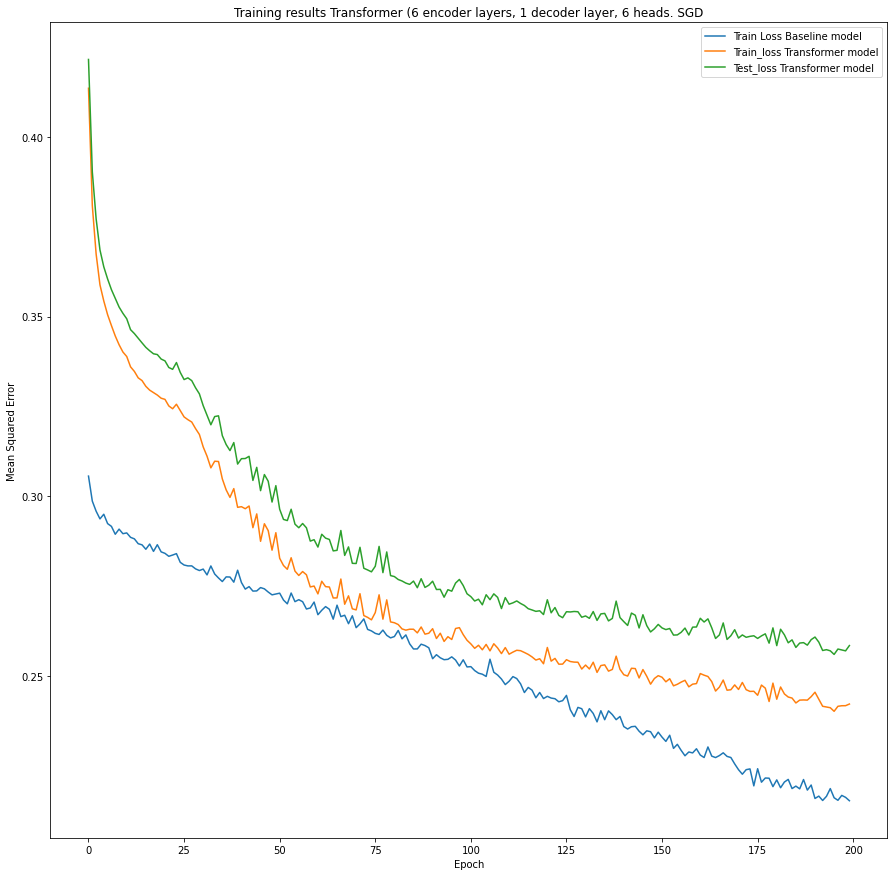

In [34]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in train_losses_whole], label= 'Train Loss Baseline model')

  ax.plot([np.mean(i) for i in train_losses_1], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [35]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.001)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_2, train_losses_2, test_losses_2 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.23it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.43it/s]



Current Mean loss Train Set:  0.34546115372979236

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.90it/s]



Current Mean loss Test Set:  0.35469468314238267


Epoch: 2 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.50it/s]



Current Mean loss Train Set:  0.3368597143768026

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.85it/s]



Current Mean loss Test Set:  0.3475312197750265


Epoch: 3 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.85it/s]



Current Mean loss Train Set:  0.33022765109512603

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.87it/s]



Current Mean loss Test Set:  0.34030158178071784


Epoch: 4 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.16it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.04it/s]



Current Mean loss Train Set:  0.33190669486345686

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.50it/s]



Current Mean loss Test Set:  0.3419271587497658


Epoch: 5 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.32it/s]



Current Mean loss Train Set:  0.3245251921039266

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.99it/s]



Current Mean loss Test Set:  0.33509101447733963


Epoch: 6 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.86it/s]



Current Mean loss Train Set:  0.3216178482155301

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.73it/s]



Current Mean loss Test Set:  0.3321487825702537


Epoch: 7 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.27it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.17it/s]



Current Mean loss Train Set:  0.32649165221706655

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.70it/s]



Current Mean loss Test Set:  0.3371188428742115


Epoch: 8 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.25it/s]



Current Mean loss Train Set:  0.3193500959326168

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.29it/s]



Current Mean loss Test Set:  0.3296667586522873


Epoch: 9 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.35it/s]



Current Mean loss Train Set:  0.31883812367439335

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.28it/s]



Current Mean loss Test Set:  0.32929288746431623


Epoch: 10 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.04it/s]



Current Mean loss Train Set:  0.320183871039473

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.82it/s]



Current Mean loss Test Set:  0.3304482802673422


Epoch: 11 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.79it/s]



Current Mean loss Train Set:  0.31640546116690405

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.39it/s]



Current Mean loss Test Set:  0.3272271126583971


Epoch: 12 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.62it/s]



Current Mean loss Train Set:  0.31663285167806776

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.95it/s]



Current Mean loss Test Set:  0.32749442974425325


Epoch: 13 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.24it/s]



Current Mean loss Train Set:  0.3136708130356873

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.98it/s]



Current Mean loss Test Set:  0.3237417462573509


Epoch: 14 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.33it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.81it/s]



Current Mean loss Train Set:  0.3162550483585876

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.00it/s]



Current Mean loss Test Set:  0.3267045318704061


Epoch: 15 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.09it/s]



Current Mean loss Train Set:  0.31301371056043864

Test with test set


100%|██████████| 396/396 [00:03<00:00, 127.00it/s]



Current Mean loss Test Set:  0.32326141831399213


Epoch: 16 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.27it/s]



Current Mean loss Train Set:  0.3158471754179923

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.31it/s]



Current Mean loss Test Set:  0.325715489610277


Epoch: 17 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.38it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.24it/s]



Current Mean loss Train Set:  0.3135036051549371

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.42it/s]



Current Mean loss Test Set:  0.323511315039312


Epoch: 18 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.94it/s]



Current Mean loss Train Set:  0.3133727261044321

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.90it/s]



Current Mean loss Test Set:  0.3232873094202292


Epoch: 19 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.22it/s]



Current Mean loss Train Set:  0.3124063629390415

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.86it/s]



Current Mean loss Test Set:  0.32227318320009446


Epoch: 20 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.97it/s]



Current Mean loss Train Set:  0.31026783478693315

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.31it/s]



Current Mean loss Test Set:  0.32036961814520337


Epoch: 21 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.57it/s]



Current Mean loss Train Set:  0.31027815449766455

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.42it/s]



Current Mean loss Test Set:  0.32017342430172546


Epoch: 22 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.79it/s]



Current Mean loss Train Set:  0.3125381539276467

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.26it/s]



Current Mean loss Test Set:  0.32296134123221193


Epoch: 23 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.38it/s]



Current Mean loss Train Set:  0.3176493188290492

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.77it/s]



Current Mean loss Test Set:  0.3277832357720895


Epoch: 24 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.40it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.58it/s]



Current Mean loss Train Set:  0.3119379999453253

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.37it/s]



Current Mean loss Test Set:  0.32228431067984514


Epoch: 25 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.46it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.26it/s]



Current Mean loss Train Set:  0.31398534294664276

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.21it/s]



Current Mean loss Test Set:  0.3238537135825615


Epoch: 26 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.24it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.17it/s]



Current Mean loss Train Set:  0.31282727672307303

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.54it/s]



Current Mean loss Test Set:  0.32308759608051996


Epoch: 27 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.53it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.76it/s]



Current Mean loss Train Set:  0.3099577961290381

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.04it/s]



Current Mean loss Test Set:  0.3200540965930982


Epoch: 28 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.87it/s]



Current Mean loss Train Set:  0.3118966466237781

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.94it/s]



Current Mean loss Test Set:  0.3213257073528237


Epoch: 29 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.71it/s]



Current Mean loss Train Set:  0.31186274005611925

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.78it/s]



Current Mean loss Test Set:  0.32187175197583257


Epoch: 30 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.03it/s]



Current Mean loss Train Set:  0.31173630568784105

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.00it/s]



Current Mean loss Test Set:  0.32207261082349403


Epoch: 31 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.66it/s]



Current Mean loss Train Set:  0.31190519892003404

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.53it/s]



Current Mean loss Test Set:  0.3221096009241812


Epoch: 32 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.73it/s]



Current Mean loss Train Set:  0.3103196434164328

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.54it/s]



Current Mean loss Test Set:  0.32118086953355807


Epoch: 33 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.70it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.84it/s]



Current Mean loss Train Set:  0.3095153690580568

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.11it/s]



Current Mean loss Test Set:  0.31941471406907745


Epoch: 34 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.78it/s]



Current Mean loss Train Set:  0.3098452823895803

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.55it/s]



Current Mean loss Test Set:  0.3209143262544666


Epoch: 35 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.25it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.45it/s]



Current Mean loss Train Set:  0.31246940940911266

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.13it/s]



Current Mean loss Test Set:  0.32419834778916956


Epoch: 36 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.40it/s]



Current Mean loss Train Set:  0.3104748868441234

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.96it/s]



Current Mean loss Test Set:  0.3203669193040843


Epoch: 37 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.81it/s]



Current Mean loss Train Set:  0.30861235340550613

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.40it/s]



Current Mean loss Test Set:  0.31886848596611406


Epoch: 38 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.17it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.03it/s]



Current Mean loss Train Set:  0.3129386695380496

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.00it/s]



Current Mean loss Test Set:  0.324227896415525


Epoch: 39 of 200
Training...


100%|██████████| 3563/3563 [01:39<00:00, 35.76it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.97it/s]



Current Mean loss Train Set:  0.3106442577896445

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.41it/s]



Current Mean loss Test Set:  0.32120857098036343


Epoch: 40 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.56it/s]



Current Mean loss Train Set:  0.3106384989801599

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.60it/s]



Current Mean loss Test Set:  0.3213557444437586


Epoch: 41 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.55it/s]



Current Mean loss Train Set:  0.3100245348939794

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.37it/s]



Current Mean loss Test Set:  0.31952452712287804


Epoch: 42 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.06it/s]



Current Mean loss Train Set:  0.3134376668014989

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.23it/s]



Current Mean loss Test Set:  0.32323484909203315


Epoch: 43 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.41it/s]



Current Mean loss Train Set:  0.30952560371548615

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.77it/s]



Current Mean loss Test Set:  0.32043926481797236


Epoch: 44 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.49it/s]



Current Mean loss Train Set:  0.3094357992578617

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.59it/s]



Current Mean loss Test Set:  0.32037623851287245


Epoch: 45 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.58it/s]



Current Mean loss Train Set:  0.3115060202695833

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.23it/s]



Current Mean loss Test Set:  0.322449646814905


Epoch: 46 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.66it/s]



Current Mean loss Train Set:  0.3085004516069286

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.69it/s]



Current Mean loss Test Set:  0.3197059284782771


Epoch: 47 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.59it/s]



Current Mean loss Train Set:  0.3094160157289025

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.20it/s]



Current Mean loss Test Set:  0.321568250279836


Epoch: 48 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.10it/s]



Current Mean loss Train Set:  0.3117409641638821

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.95it/s]



Current Mean loss Test Set:  0.3223643210914099


Epoch: 49 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.33it/s]



Current Mean loss Train Set:  0.30965018546751905

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.88it/s]



Current Mean loss Test Set:  0.3203706610759701


Epoch: 50 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.62it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.01it/s]



Current Mean loss Train Set:  0.3070714975692334

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.64it/s]



Current Mean loss Test Set:  0.31758310777520893


Epoch: 51 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.33it/s]



Current Mean loss Train Set:  0.31270748702221096

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.28it/s]



Current Mean loss Test Set:  0.32360795475166254


Epoch: 52 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.74it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.76it/s]



Current Mean loss Train Set:  0.30882276311085993

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.10it/s]



Current Mean loss Test Set:  0.3198472909779862


Epoch: 53 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.24it/s]



Current Mean loss Train Set:  0.30689612694070006

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.40it/s]



Current Mean loss Test Set:  0.31712193937614713


Epoch: 54 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.37it/s]



Current Mean loss Train Set:  0.3087606682574652

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.90it/s]



Current Mean loss Test Set:  0.31936883591491766


Epoch: 55 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.85it/s]



Current Mean loss Train Set:  0.30770810618432026

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.98it/s]



Current Mean loss Test Set:  0.3175136907157874


Epoch: 56 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.15it/s]



Current Mean loss Train Set:  0.3091768913939198

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.02it/s]



Current Mean loss Test Set:  0.3193708062548228


Epoch: 57 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.42it/s]



Current Mean loss Train Set:  0.3073772517982541

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.52it/s]



Current Mean loss Test Set:  0.3177585294376118


Epoch: 58 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.05it/s]



Current Mean loss Train Set:  0.3098688941702995

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.53it/s]



Current Mean loss Test Set:  0.3209932939234105


Epoch: 59 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.98it/s]



Current Mean loss Train Set:  0.30738765741963753

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.25it/s]



Current Mean loss Test Set:  0.3177889757084124


Epoch: 60 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.17it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.68it/s]



Current Mean loss Train Set:  0.31136217099200664

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.71it/s]



Current Mean loss Test Set:  0.32242710205415887


Epoch: 61 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.17it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.27it/s]



Current Mean loss Train Set:  0.30777149326072595

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.23it/s]



Current Mean loss Test Set:  0.3179586101323366


Epoch: 62 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.90it/s]



Current Mean loss Train Set:  0.30941142542264183

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.20it/s]



Current Mean loss Test Set:  0.32028622197156603


Epoch: 63 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.99it/s]



Current Mean loss Train Set:  0.3098635086217289

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.68it/s]



Current Mean loss Test Set:  0.32051483861575225


Epoch: 64 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.72it/s]



Current Mean loss Train Set:  0.3095440846976858

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.67it/s]



Current Mean loss Test Set:  0.31970896361151124


Epoch: 65 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.67it/s]



Current Mean loss Train Set:  0.30819804582524224

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.27it/s]



Current Mean loss Test Set:  0.31842651607638056


Epoch: 66 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.93it/s]



Current Mean loss Train Set:  0.30945915876857155

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.93it/s]



Current Mean loss Test Set:  0.32081552941088726


Epoch: 67 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.34it/s]



Current Mean loss Train Set:  0.3123891067356833

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.46it/s]



Current Mean loss Test Set:  0.3229142923020955


Epoch: 68 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.34it/s]



Current Mean loss Train Set:  0.3099791430566306

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.92it/s]



Current Mean loss Test Set:  0.31952708989682826


Epoch: 69 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.32it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.96it/s]



Current Mean loss Train Set:  0.30858962483748004

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.90it/s]



Current Mean loss Test Set:  0.3191920992626686


Epoch: 70 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.19it/s]



Current Mean loss Train Set:  0.3075380967096134

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.61it/s]



Current Mean loss Test Set:  0.31753887484471005


Epoch: 71 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.89it/s]



Current Mean loss Train Set:  0.3102728565430795

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.79it/s]



Current Mean loss Test Set:  0.3217116304569774


Epoch: 72 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.56it/s]



Current Mean loss Train Set:  0.3086608746205359

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.43it/s]



Current Mean loss Test Set:  0.32055499875033744


Epoch: 73 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.67it/s]



Current Mean loss Train Set:  0.30866449759343084

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.28it/s]



Current Mean loss Test Set:  0.3197524586711267


Epoch: 74 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.62it/s]



Current Mean loss Train Set:  0.3096616215525033

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.49it/s]



Current Mean loss Test Set:  0.32029271035483386


Epoch: 75 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.23it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.83it/s]



Current Mean loss Train Set:  0.3072933114640605

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.44it/s]



Current Mean loss Test Set:  0.3183293306466305


Epoch: 76 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.25it/s]



Current Mean loss Train Set:  0.3085953584847877

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.08it/s]



Current Mean loss Test Set:  0.3193621681720922


Epoch: 77 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.21it/s]



Current Mean loss Train Set:  0.31095506364404907

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.99it/s]



Current Mean loss Test Set:  0.32274496002179204


Epoch: 78 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.38it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.81it/s]



Current Mean loss Train Set:  0.3100920013023199

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.51it/s]



Current Mean loss Test Set:  0.32090841098265216


Epoch: 79 of 200
Training...


100%|██████████| 3563/3563 [01:40<00:00, 35.38it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.94it/s]



Current Mean loss Train Set:  0.30973511715551594

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.98it/s]



Current Mean loss Test Set:  0.3196232098935529


Epoch: 80 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.00it/s]



Current Mean loss Train Set:  0.31005766802529355

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.97it/s]



Current Mean loss Test Set:  0.32042260752106555


Epoch: 81 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.51it/s]



Current Mean loss Train Set:  0.3098588153979198

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.41it/s]



Current Mean loss Test Set:  0.32028383946027417


Epoch: 82 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.19it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.83it/s]



Current Mean loss Train Set:  0.31051617343665644

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.48it/s]



Current Mean loss Test Set:  0.3217679456704193


Epoch: 83 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.26it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.03it/s]



Current Mean loss Train Set:  0.3096308757979951

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.99it/s]



Current Mean loss Test Set:  0.32084842748714215


Epoch: 84 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.39it/s]



Current Mean loss Train Set:  0.3085448270788562

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.17it/s]



Current Mean loss Test Set:  0.318618201584828


Epoch: 85 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.23it/s]



Current Mean loss Train Set:  0.31000864108459286

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.39it/s]



Current Mean loss Test Set:  0.3205263382670554


Epoch: 86 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.56it/s]



Current Mean loss Train Set:  0.30826484997253084

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.71it/s]



Current Mean loss Test Set:  0.31846739231335996


Epoch: 87 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.30it/s]



Current Mean loss Train Set:  0.3117391584551371

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.65it/s]



Current Mean loss Test Set:  0.32190953629712266


Epoch: 88 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.33it/s]



Current Mean loss Train Set:  0.30869882416848954

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.26it/s]



Current Mean loss Test Set:  0.3184504409631093


Epoch: 89 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.29it/s]



Current Mean loss Train Set:  0.30605107261463393

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.72it/s]



Current Mean loss Test Set:  0.316199947825887


Epoch: 90 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.10it/s]



Current Mean loss Train Set:  0.30788491056552936

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.69it/s]



Current Mean loss Test Set:  0.31892596433560055


Epoch: 91 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.42it/s]



Current Mean loss Train Set:  0.30764193366559545

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.68it/s]



Current Mean loss Test Set:  0.3183430673347579


Epoch: 92 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.60it/s]



Current Mean loss Train Set:  0.31129341445384384

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.30it/s]



Current Mean loss Test Set:  0.3218835311556103


Epoch: 93 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.98it/s]



Current Mean loss Train Set:  0.3095088500091443

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.22it/s]



Current Mean loss Test Set:  0.3203419865005546


Epoch: 94 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.39it/s]



Current Mean loss Train Set:  0.3065408709768228

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.71it/s]



Current Mean loss Test Set:  0.3170578081273671


Epoch: 95 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.31it/s]



Current Mean loss Train Set:  0.30892763356880765

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.43it/s]



Current Mean loss Test Set:  0.32063085390160784


Epoch: 96 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.43it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.89it/s]



Current Mean loss Train Set:  0.310383223584787

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.23it/s]



Current Mean loss Test Set:  0.32160776386959383


Epoch: 97 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.76it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.43it/s]



Current Mean loss Train Set:  0.3105266712419846

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.51it/s]



Current Mean loss Test Set:  0.3214249473178025


Epoch: 98 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.62it/s]



Current Mean loss Train Set:  0.30786684471219905

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.09it/s]



Current Mean loss Test Set:  0.3192348875895594


Epoch: 99 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.75it/s]



Test with training set


 73%|███████▎  | 2590/3563 [00:21<00:07, 123.03it/s]


KeyboardInterrupt: ignored

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_2], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_2], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. ADAM")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_3, train_losses_3, test_losses_3 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=1,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=1,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_4, train_losses_4, test_losses_4 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer smallest model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer smallest model')
  ax.set_title("Training results Transformer (1 encoder layers, 1 decoder layer, 1 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=10,
                      num_decoder_layers=5,
                      feature_size=18,
                      output_size=18,
                      num_heads=9,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_5, train_losses_5, test_losses_5 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_5], label= 'Train_loss Transformer bigger model')
  ax.plot([np.mean(i) for i in test_losses_5], label= 'Test_loss Transformer bigger model')
  ax.set_title("Training results Transformer (10 encoder layers, 5 decoder layer, 9 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

# Training using PCA in the dataset

In [ ]:
df =  dataset_norm.copy()

df.pop('time')

df.head()

,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [ ]:
# Train using PCA

pca = PCA(n_components=6)
df_pca = pca.fit(df)
df_transformed_pca = df_pca.transform(df)

def create_sequece_dataloaders_pca(dataset_norm):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of 30 measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):    
    data = np.array(dataset_norm[i:i+30, :])
    next = np.array(dataset_norm[i+30, :], dtype= float)
    target = np.array(dataset_norm[i+31, :], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=60,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=60,
      shuffle=True
  )

  return loader_train, loader_test

loader_train_seq_pca, loader_test_seq_pca = create_sequece_dataloaders_pca(df_transformed_pca)


def training_transformer_PCA(model, optimizer, criterion, train_loader, test_loader, n_epochs, device, pca):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

100%|██████████| 63300/63300 [00:00<00:00, 199403.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer_pca = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=6,
                      output_size=6,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer_pca.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_pca, train_losses_6, test_losses_6 = training_transformer_PCA(
      model= model_transformer_pca, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_pca, 
      test_loader= loader_test_seq_pca, 
      n_epochs= n_epochs,
      device=device,
      pca=df_pca)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.97it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.55it/s]



Current Mean loss Train Set:  1.005661331289693

Test with test set


100%|██████████| 106/106 [00:00<00:00, 113.50it/s]



Current Mean loss Test Set:  1.0412167766184177


Epoch: 2 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.82it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.31it/s]



Current Mean loss Train Set:  0.9819152564124057

Test with test set


100%|██████████| 106/106 [00:00<00:00, 114.43it/s]



Current Mean loss Test Set:  1.017743021812079


Epoch: 3 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 32.18it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.36it/s]



Current Mean loss Train Set:  0.9680814192797008

Test with test set


100%|██████████| 106/106 [00:00<00:00, 115.10it/s]



Current Mean loss Test Set:  1.0035489555799737


Epoch: 4 of 200
Training...


100%|██████████| 950/950 [00:32<00:00, 29.56it/s]



Test with training set


 85%|████████▌ | 812/950 [00:07<00:01, 113.53it/s]


KeyboardInterrupt: ignored